# Ground Truth Image Generation
## Catchment scale land use data for Australia - Commodities (CLUMC) - Update December 2020

### Purpose
This notebook extracts the polygon areas associated with each location and crop and creates a bitmask layer to serve as the ground truth for the training of the deep learning model.


In [1]:
import os
import time

from datetime import datetime
import numpy as np
import matplotlib.pyplot as plt
import folium
import pandas as pd
import geopandas as gpd

from shapely.geometry import Polygon

# My helper class
from helperfunctions import begin_timer, end_timer, saveDataset, loadDataset
from dea_helperfunctions import DEA_HelperFunctions

### Constants

In [2]:
epsg3577 = 'epsg:3577'            # EPSG:3577: GDA94 / Australian Albers projection
cropregions_geojsonfile = '../datasets/crop_regions.json'

# configure helper functions
dea_fns = DEA_HelperFunctions()
basepath = "../datasets/Sentinel2withIndices_"
fileextn = ".pkl"

filespecifier = "DublinSA_2020to2022_Mar"

### Load crop regions

In [3]:
crop_regions = gpd.read_file(cropregions_geojsonfile)
crop_regions = crop_regions.to_crs(epsg3577)
crop_regions

,Crop Type,Broad Type,Source_yr,State,Area (ha),Lucodev8n,Tertiary,date,geometry
0,olives,Fruits,2015,ACT,25.311300,442,4.4.2 Irrigated olives,2012,"POLYGON ((1551820.086 -3964654.231, 1551827.97..."
1,olives,Fruits,2015,ACT,0.973185,442,4.4.2 Irrigated olives,2012,"POLYGON ((1554509.456 -3961489.157, 1554528.31..."
2,citrus,Fruits,2014,WA,0.103560,448,4.4.8 Irrigated citrus,2014,"POLYGON ((-1527713.862 -3784728.068, -1527742...."
3,citrus,Fruits,2014,WA,0.126099,448,4.4.8 Irrigated citrus,2014,"POLYGON ((-1527648.368 -3784682.135, -1527691...."
4,citrus,Fruits,2014,WA,0.594405,448,4.4.8 Irrigated citrus,2014,"POLYGON ((-1543937.097 -3776665.195, -1543928...."
...,...,...,...,...,...,...,...,...,...
32664,olives,Fruits,2014,Tas,3.070510,442,4.4.2 Irrigated olives,2019,"POLYGON ((1280323.074 -4578309.447, 1280501.23..."
32665,olives,Fruits,2017,Tas,2.447330,442,4.4.2 Irrigated olives,2019,"POLYGON ((1217501.249 -4591585.948, 1217712.89..."
32666,olives,Fruits,2017,Tas,2.536480,442,4.4.2 Irrigated olives,2019,"POLYGON ((1281149.766 -4597046.757, 1281086.75..."
32667,olives,Fruits,2016,Tas,16.149300,342,3.4.2 Olives,2019,"POLYGON ((1302113.176 -4618451.941, 1302137.17..."


### Load tile polygons

<AxesSubplot:>

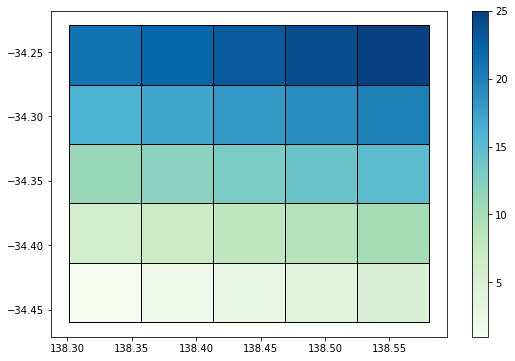

In [4]:
#Extract GeoDataFrame containing polygons
gdf_surveyarea = loadDataset(basepath + filespecifier + "_polygons" + fileextn)

# display Tile areas using GeoDataFrame
gdf_surveyarea.set_crs(epsg3577)
gdf_surveyarea.plot(column="tile", kind='geo', figsize=(9,6), cmap='GnBu', legend=True, edgecolor="black")

### Create new GeoDataFrame for Crop areas containing only Polygons

In [16]:
crop_regions_polyonly = crop_regions.drop(columns=['Crop Type', 'Broad Type', 'Source_yr', 'State', 'Area (ha)',
                                                   'Lucodev8n', 'Tertiary', 'date'])
crop_regions_polyonly.crs

<Projected CRS: EPSG:3577>
Name: GDA94 / Australian Albers
Axis Info [cartesian]:
- E[east]: Easting (metre)
- N[north]: Northing (metre)
Area of Use:
- name: Australia - onshore
- bounds: (112.85, -43.7, 153.69, -9.86)
Coordinate Operation:
- name: Australian Albers
- method: Albers Equal Area
Datum: Geocentric Datum of Australia 1994
- Ellipsoid: GRS 1980
- Prime Meridian: Greenwich

### Test GeoDataFrame.overlay( 'Intersection' )

## Read https://stackoverflow.com/questions/64200595/geopandas-overlay-intersection-returns-zero-rows

In [20]:
testtile_poly = Polygon([(138.4302758484676, -34.499250475423985), (138.57682303177802, -34.499250475423985),
                         (138.4302758484676,-34.378560676926654), (138.57682303177802, -34.378560676926654)])
print(testtile_poly)
print("-------------------------")

testtile_gs = gpd.GeoSeries(testtile_poly)
print(testtile_gs)
print("-------------------------")

testtile_gdf = gpd.GeoDataFrame(geometry=testtile_gs, crs=epsg3577)
print(testtile_gdf)
print("-------------------------")

testtile_crop_intersection = testtile_gdf.overlay(crop_regions_polyonly, how='intersection', keep_geom_type=True)
print(testtile_crop_intersection)
print("-------------------------")


POLYGON ((138.4302758484676 -34.49925047542398, 138.576823031778 -34.49925047542398, 138.4302758484676 -34.37856067692665, 138.576823031778 -34.37856067692665, 138.4302758484676 -34.49925047542398))
-------------------------
0    POLYGON ((138.43028 -34.49925, 138.57682 -34.4...
dtype: geometry
-------------------------
                                            geometry
0  POLYGON ((138.430 -34.499, 138.577 -34.499, 13...
-------------------------
Empty GeoDataFrame
Columns: [geometry]
Index: []
-------------------------


### Iterate each tile and select crop-regions covering that tile

In [8]:
# Iterate through each surveyarea tile
#for i in range(gdf_surveyarea.shape[0]):
i = 19
print(gdf_surveyarea["geometry"][i+1])
tile_df = gpd.GeoDataFrame(geometry=gpd.GeoSeries(gdf_surveyarea["geometry"][i+1]), crs=epsg3577)

tile_crop_intersection = crop_regions.overlay(tile_df, how='intersection')
#tile_crop_intersection = crop_regions_polyonly.clip(mask=tile_df, keep_geom_type=True)

#print(tile_df["geometry"])
print(tile_crop_intersection)
#ax = tile_crop_intersection.plot(cmap='tab10')

POLYGON ((138.5248360122671 -34.32148028332747, 138.5248360122671 -34.27543501710443, 138.5806805980488 -34.27543501710443, 138.5806805980488 -34.32148028332747, 138.5248360122671 -34.32148028332747))
Empty GeoDataFrame
Columns: [Crop Type, Broad Type, Source_yr, State, Area (ha), Lucodev8n, Tertiary, date, geometry]
Index: []


for each tile...
https://stackoverflow.com/questions/14697442/faster-way-of-polygon-intersection-with-shapely


In [ ]:
from shapely.ops import cascaded_union
from rtree import index

In [ ]:
idx = index.Index()

# Populate R-tree index with bounds of grid cells
for pos, cell in enumerate(grid_cells):
    # assuming cell is a shapely object
    idx.insert(pos, cell.bounds)

# Loop through each Shapely polygon
for poly in polygons:
    # Merge cells that have overlapping bounding boxes
    merged_cells = cascaded_union([grid_cells[pos] for pos in idx.intersection(poly.bounds)])
    # Now do actual intersection
    print(poly.intersection(merged_cells).area)